# San Francisco Rental Prices Dashboard

In this notebook, we will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [25]:
import plotly.express as px
import panel as pn
from panel.interact import interact
import pandas as pd
import os
from pathlib import Path
from dotenv import load_dotenv

In [26]:
# Set up Panel Plotly extension
pn.extension('plotly')

In [27]:
# Import hvplot.pandas after pn.extension
# This avoids plotly initialization failure
import hvplot.pandas

In [28]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [29]:
# Read the census data into a Pandas DataFrame
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

# Group data by year
sfo_grouped_data = sfo_data.groupby('year').mean()

- - -

## Panel Visualizations

In this section, we will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

In [30]:
# Define Panel Visualization Functions


################################################### YEARLY MARKET ANALYSIS PLOTS ##############################

def housing_units_per_year():
    """Housing Units Per Year."""
    
    min = sfo_grouped_data['housing_units'].min()
    max = sfo_grouped_data['housing_units'].max()
    std = sfo_grouped_data['housing_units'].std()

    min1 = min - std
    max1 = max + std

    housing_units_plot = px.bar(
        sfo_grouped_data,
        y='housing_units',
        range_y =(min1,max1),
        title="Average Housing Units in San Francisco from 2010 to 2016"
    )
    
    return housing_units_plot
    


def average_sales_price():
    """Average Sales Price Per Square Foot in San Francisco Per Year."""

    sales_price_plot = px.line(
        sfo_grouped_data,
        y='sale_price_sqr_foot',
        title = 'Average Sale Price Per Square Foot in San Francisco'
    )
    
    return sales_price_plot

    
    
def average_gross_rent():
    """Average Gross Rent Per Year."""
    
    gross_rent_plot = px.line(
        sfo_grouped_data,
        y='gross_rent', 
        title = 'Average Monthly Rent in San Francisco'
    )
    
    return gross_rent_plot
  

############################################# NEIGHBORHOOD ANALYSIS ##################################################

# Data preparation

# Group SFO census data by neighborhood and year with mean() as aggregation function
sfo_data_by_nhood = sfo_data.groupby(['neighborhood','year']).mean()
sfo_data_by_nhood = sfo_data_by_nhood.reset_index()

# Unique Neighborhood data to construct the drop down
# Group the DataFrame by 'neighborhood' with nunique() to get the unique neighborhood as index in the grouped DataFrame
# Dump the index 
# Typecast index to a list of unique neighborhood

unique_neighborhood_df = sfo_data_by_nhood.groupby('neighborhood').nunique()
unique_neighborhood_index = unique_neighborhood_df.index
unique_neighborhood_list = list(unique_neighborhood_index)



# Define function to choose a neighborhood and return the interactive plot

def average_price_by_neighborhood(Neighborhood):
    """Average Prices by Neighborhood."""
    df3 = sfo_data_by_nhood[sfo_data_by_nhood['neighborhood'] == Neighborhood]
    return df3.hvplot(
        x="year",
        y="sale_price_sqr_foot",
        title="Sale price per square foot for neighborhood: " + Neighborhood,
    )
    

    
# Top most expensive neighborhoods    
# Data preparation 

sfo_price_data_by_nhood = sfo_data.groupby('neighborhood').mean()

# use nlargest() function to pickup rows from the DataFrame with top n sale price.
top10 = sfo_price_data_by_nhood.nlargest(10, "sale_price_sqr_foot")



# Define function to plot sale price of 10 most expensive neighborhoods

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    most_expensive_neighborhoods_plot = top10.hvplot.bar(
        x="neighborhood", 
        y="sale_price_sqr_foot", 
        xlabel="Neighborhood", 
        ylabel="Average price per sqft", 
        title="Top 10 expensive neighborhoods in San Francisco",
        rot=90
        ).opts(yformatter="%.0f")
    
    return most_expensive_neighborhoods_plot




# Define function to choose a neighborhood and return the interactive plot with monthly gross rent and sales price per square foot
def neighborhoods_rent_sales(Neighborhood):
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    
    df3 = sfo_data_by_nhood[sfo_data_by_nhood['neighborhood'] == Neighborhood]
    
    rent_sales_plot = df3.hvplot.bar(
        'year',
        ['gross_rent','sale_price_sqr_foot'],  # Col. names in the list will create clustered bar plot
        title = "Sales Price per Square Foot vs. Gross Rent of Neighborhood: " + Neighborhood,
        stacked =False,
        xlabel = "",                   # To get rid of appearing col. names as label of x-axis. We already have meanigful labels   
        ylabel = "US Dollar ($)",      # Label y-axis
        width=700,
        height=500,
        rot = 90
    )
    return rent_sales_plot



########################################## SCATTER MAPBOX PLOT ########################################################    

# Load neighborhoods coordinates data
nhood_coordinates = pd.read_csv(Path("Data/neighborhoods_coordinates.csv"))
nhood_coordinates.rename(columns={"Neighborhood":"neighborhood"},inplace=True)
nhood_coordinates.set_index('neighborhood',inplace=True)

# Calculate the mean values for each neighborhood
sfo_mean_values_by_nhood = sfo_data.groupby('neighborhood').mean()

# Join the average values with the neighborhood locations
nhood_meanvalue_loc = pd.concat([sfo_mean_values_by_nhood,nhood_coordinates],axis='columns', join='inner').reset_index()

def neighborhood_map():
    """Neighborhood Map."""
    
    # Create a scatter mapbox to analyze neighborhood info
    scatter_mapbox_plot = px.scatter_mapbox(
        nhood_meanvalue_loc,
        lat="Lat",
        lon="Lon",
        size='sale_price_sqr_foot',
        color='gross_rent',
        color_continuous_scale=px.colors.cyclical.IceFire,
        title="Average sale price per square foot and gross rent in SFO",
        zoom=3,
        width=1000,
        height = 600
    )
    return scatter_mapbox_plot


##################################### PARALLEL PLOTS ###################################################################
    
sfo_data_noindex = sfo_data.reset_index()
top10_list = list(top10.index)
# Fetch the data from all expensive neighborhoods per year.
rows_in_expensive_neighborhood = sfo_data_noindex["neighborhood"].isin(top10_list)
df_expensive_neighborhoods_per_year = sfo_data_noindex[rows_in_expensive_neighborhood]

def parallel_coordinates():
    """Parallel Coordinates Plot."""
    
    parallel_coordinates_plot = px.parallel_coordinates(df_expensive_neighborhoods_per_year[["sale_price_sqr_foot","housing_units","gross_rent"]], 
                        color = 'sale_price_sqr_foot', 
                        title = 'Parallel Coordinates analysis of most expensive San Franscisco neighborhoods'
                                                       )
    return parallel_coordinates_plot


def parallel_categories():
    """Parallel categories Plot."""

    parallel_categories_plot = px.parallel_categories(
    df_expensive_neighborhoods_per_year,
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
    labels={
        "neighborhood": "Neighborhood",
        "sale_price_sqr_foot": "Sale price/sqft",
        "housing_units": "No. of housing units",
        "gross_rent": "Gross rent"
    },
    title = "Parallel Categories analysis of most expensive San Franscisco neighborhoods"
    )
    return parallel_categories_plot
    

def sunburst():
    """Sunburst Plot."""
    
    # YOUR CODE HERE!


## Panel Dashboard

In this section, we will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [31]:

# CREATE A TAB LAYOUT FOR THE DASHBOARD 
# First tab setting context and what to expect from the dashboard. Starts with sale prices and gross rents of neighborhoods in SFO map
welcome_column = pn.Column(
    "This dashboard presents a visual analysis of hostorical prices of house units, sale prices per square foot and gross rents of the houses in the neighborhoods of San Francisco, California from 2010 to 2016. You can navigate through the tabs above to explore, more details about the evolution of the real estate market of the \nGolden City across these years",
    neighborhood_map()
)

# Second tab with visuals of yearly trend of housing units, sale price and gross rent
yearly_column = pn.Column(
    housing_units_per_year(),
    average_sales_price(), 
    average_gross_rent()
)

# Third tab with interactive visuals at neighborhood level - features sale price, gross rent based on the neighborhood selected 
# Also shows shows top 10 expensive neighborhood of San Francisco
neighborhood_column = pn.Column(
    interact(average_price_by_neighborhood, Neighborhood = unique_neighborhood_list),
    top_most_expensive_neighborhoods(),
    interact(neighborhoods_rent_sales, Neighborhood = unique_neighborhood_list)
)

# Forth tab with parallel plots 
parallel_column = pn.Column(
    parallel_coordinates(),
    parallel_categories()
)



# CREATE THE TASHBOARD BY STRINING ALL THE ABOVE TABS
hosing_investment_dashboard = pn.Tabs(
    ("Welcome", welcome_column), 
    ("Yearly Market Analysis", yearly_column),
    ("Neighborhood Analysis", neighborhood_column),
    ("Parallel Plots Analysis", parallel_column)
)


## Serve the Panel Dashboard

In [33]:
# Serve the# dashboard
hosing_investment_dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Column
        [0] Plotly(Figure, viewport={'xaxis.range': [2009.5, ...})
        [1] Plotly(Figure, viewport={'xaxis.range': [2010, ...})
        [2] Plotly(Figure, viewport={'xaxis.range': [2010, ...})
    [2] Column
        [0] Column
            [0] Column
                [0] Select(name='Neighborhood', options=['Alamo Square', ...], value='Alamo Square')
            [1] Row
                [0] HoloViews(Curve, name='interactive02313')
        [1] HoloViews(Bars)
        [2] Column
            [0] Column
                [0] Select(name='Neighborhood', options=['Alamo Square', ...], value='Alamo Square')
            [1] Row
                [0] HoloViews(Bars, name='interactive02519')
    [3] Column
        [0] Plotly(Figure)
        [1] Plotly(Figure)

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [34]:
# housing_units_per_year()

In [35]:
# average_gross_rent()

In [36]:
# average_sales_price()

In [37]:
# average_price_by_neighborhood()

In [38]:
top_most_expensive_neighborhoods()

:Bars   [neighborhood]   (sale_price_sqr_foot)

In [39]:
# most_expensive_neighborhoods_rent_sales()

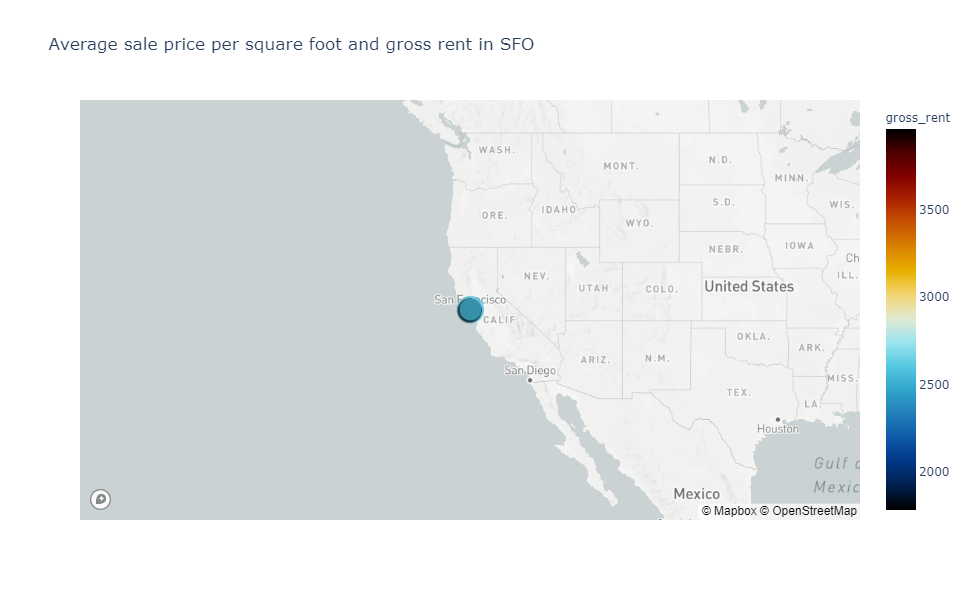

In [44]:
neighborhood_map().show()

In [41]:
# parallel_categories()

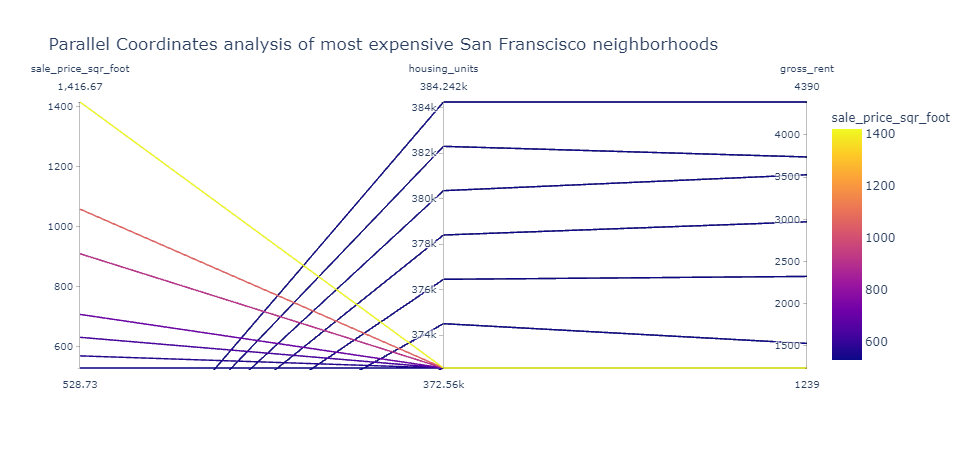

In [42]:
parallel_coordinates()

In [43]:
# sunburst()